In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time
import json

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_files = ["articles2019-05-31_0-7000.csv",
                 "articles2019-05-31_7000-14000.csv",
                 "articles2019-05-31_14000-16654.csv"]
article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]

article_df = pd.concat(article_df)
article_df = article_df.reset_index()

# events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
event_path = os.path.join(data_folder, "eventDict2019-05-31.json")
with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)
print(events.keys())
article_df.head(3)

dict_keys(['singletons', 'incompleteFingerprints', 'algoGroups', 'events', 'wordDict', 'entityDict'])


,index,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc
0,0,0,sfgate.com,2019-05-31T07:45:29-04:00,False,https://www.sfgate.com/news/article/Beto-O-Rou...,"Beto O'Rourke bolstering Iowa staff, field off...","Beto O'Rourke bolstering Iowa staff, field off...","{'wordCounts': {'31293': 2, '38276': 5, '15430...",NaN,None
1,1,1,centurylink.net/news,2019-05-31T11:36:56-04:00,True,https://centurylink.net/news/read/category/new...,Robbins Geller Rudman & Dowd LLP Announces Pro...,TO: ### ALL PERSONS WHO PURCHASED DIPLOMAT PHA...,"{'wordCounts': {'744': 3, '421': 3, '13018': 5...",NaN,None
2,2,2,news.google.com,2019-05-31T15:32:23-04:00,True,https://news.google.com/stories/CAAqOQgKIjNDQk...,NaN,iMoreverified_user ### iMore ### From buying u...,"{'wordCounts': {'710161': 1, '403001': 1, '226...",NaN,None


In [3]:
N = len(article_df)
N_top50 = np.sum(1 - np.isnan(article_df["event"]))
print("Number of singletons: %d" % len(events['singletons']))
print("Number of articles clustered into top 50 events: %d/%d (.%d)" % (N_top50, N, round(N_top50/N, 2) * 100))

ac = tc.ArticleComparisons()

Number of singletons: 10683
Number of articles clustered into top 50 events: 4072/16654 (.24)


Text(0.5, 1.0, 'Number of sentences in 1000 sample articles')

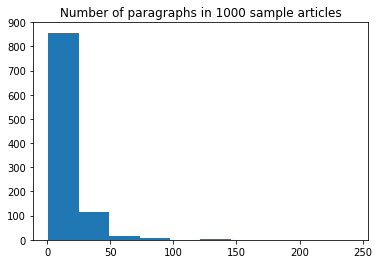

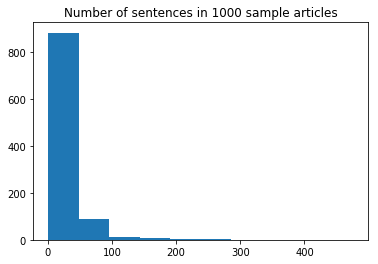

In [19]:
n = 1000
sample = article_df.loc[random.sample(range(len(article_df)), n), "id"]
article_dict = dict_by_ids(article_df, sample)

n_paras = [len(article_dict[id].paragraphs) for id in article_dict.keys()]
n_sentences = [len(article_dict[id].get_sentences()) for id in article_dict.keys()]

plt.hist(n_paras)
plt.title("Number of paragraphs in %d sample articles" % n)

plt.figure()
plt.hist(n_sentences)
plt.title("Number of sentences in %d sample articles" % n)

Text(0.5, 1.0, 'Number of sentences in 1000 sample articles')

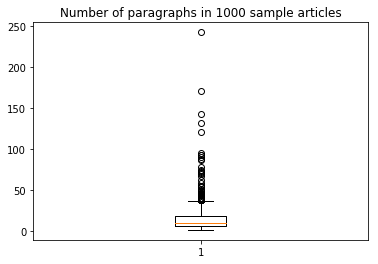

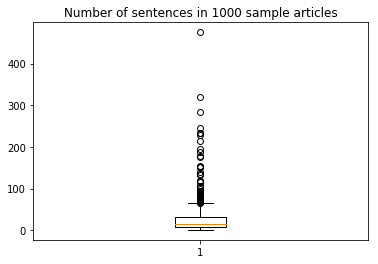

In [20]:
plt.boxplot(n_paras)
plt.title("Number of paragraphs in %d sample articles" % n)

plt.figure()
plt.boxplot(n_sentences)
plt.title("Number of sentences in %d sample articles" % n)

In [21]:
score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 250 random articles, 89.2% unique
# 400 random articles, 89.0% unique, 10 min
# 800 random articles, 83.375% unique, 60 min 
# 1000 random articles, 84.4% unique, 1.5 hrs

0 / 1000 done, 0.0 seconds elapsed
100 / 1000 done, 804.62 seconds elapsed
200 / 1000 done, 1491.58 seconds elapsed
300 / 1000 done, 3125.13 seconds elapsed
400 / 1000 done, 3888.54 seconds elapsed
500 / 1000 done, 4454.52 seconds elapsed
600 / 1000 done, 4925.0 seconds elapsed
700 / 1000 done, 5378.63 seconds elapsed
800 / 1000 done, 5700.07 seconds elapsed
900 / 1000 done, 5860.98 seconds elapsed


0.844

Text(0.5, 1.0, 'Number of sentences in 1000 sample articles')

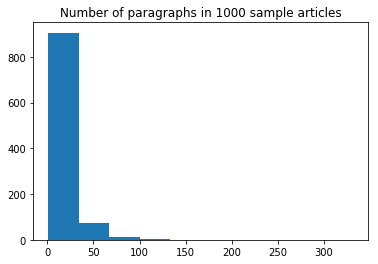

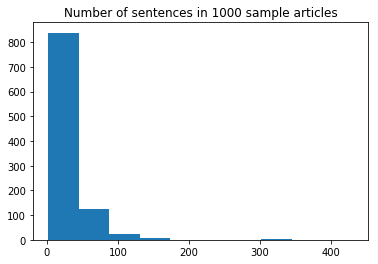

In [15]:
n = 1000
sample = article_df.loc[random.sample(events['singletons'], n), "id"]
article_dict = dict_by_ids(article_df, sample)
#sample = article_df.loc[article_df["event"] == events[5], "id"]

start = time.time()

n_paras = [len(article_dict[id].paragraphs) for id in article_dict.keys()]
n_sentences = [len(article_dict[id].get_sentences()) for id in article_dict.keys()]

plt.hist(n_paras)
plt.title("Number of paragraphs in %d sample articles" % n)

plt.figure()
plt.hist(n_sentences)
plt.title("Number of sentences in %d sample articles" % n)
# 1000 comparisons takes ~15s: estimated >2 hours for 1000 articles 
# takes about ~1min for 100 docs, ~4min for 120 docs (44%), ~28min for 321 docs (event 6, 62%), 
# 100 singleton articles: 96%, 200 (10min): 93% unique

In [16]:
score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()

print("%s seconds taken" % np.round(time.time() - start, 2))
# 86.5% unique for n = 800 random singleton articles, ~1 hr
# 85.3% unique for n = 1000 random singleton articles, ~1.5 hrs

0 / 1000 done, 0.0 seconds elapsed
100 / 1000 done, 895.55 seconds elapsed
200 / 1000 done, 1786.3 seconds elapsed
300 / 1000 done, 2688.13 seconds elapsed
400 / 1000 done, 3336.17 seconds elapsed
500 / 1000 done, 3876.83 seconds elapsed
600 / 1000 done, 4724.13 seconds elapsed
700 / 1000 done, 5172.37 seconds elapsed
800 / 1000 done, 5431.54 seconds elapsed
900 / 1000 done, 5611.83 seconds elapsed
5664.26 seconds taken


In [17]:
ac.prop_unique_clusters()

0.853

Text(0.5, 1.0, 'Number of sentences in 1000 sample articles')

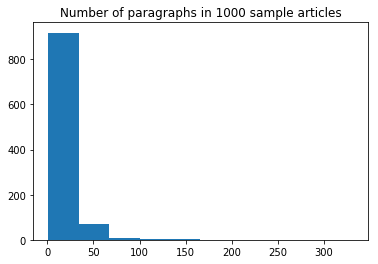

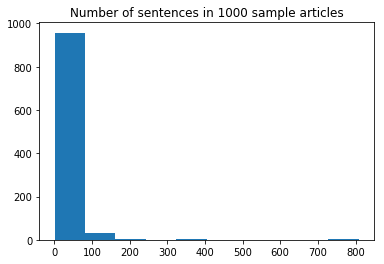

In [13]:
n = 1000
sample = article_df.loc[random.sample(range(len(article_df)), n), "id"]
article_dict = dict_by_ids(article_df, sample)

n_paras = [len(article_dict[id].paragraphs) for id in article_dict.keys()]
n_sentences = [len(article_dict[id].get_sentences()) for id in article_dict.keys()]

plt.hist(n_paras)
plt.title("Number of paragraphs in %d sample articles" % n)

plt.figure()
plt.hist(n_sentences)
plt.title("Number of sentences in %d sample articles" % n)

In [14]:
score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 1000 articles, 1 hour 30 min, 83.8% unique articles

0 / 1000 done, 0.0 seconds elapsed
100 / 1000 done, 1146.3 seconds elapsed
200 / 1000 done, 2108.86 seconds elapsed
300 / 1000 done, 2904.28 seconds elapsed
400 / 1000 done, 3601.97 seconds elapsed
500 / 1000 done, 4191.65 seconds elapsed
600 / 1000 done, 4672.2 seconds elapsed
700 / 1000 done, 4954.9 seconds elapsed
800 / 1000 done, 5341.67 seconds elapsed
900 / 1000 done, 5486.27 seconds elapsed


0.838

Average % unique articles, weighted by cluster size (thresh = 0.25):  0.5567288801873772
Average % unique articles, weighted by cluster size (thresh = 0.75):  0.6736247543388998


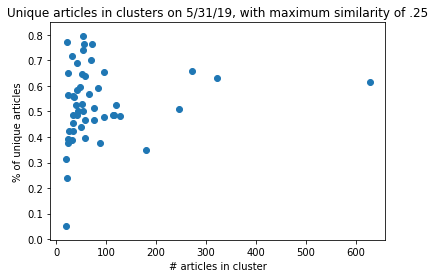

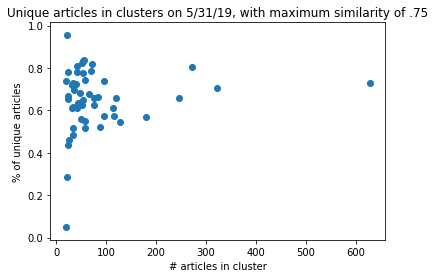

In [8]:
results = pd.read_csv("results_20190531_clusters.csv")
plt.scatter(results.loc[:, "n"], results.loc[:, "unique25"])
plt.title("Unique articles in clusters on 5/31/19, with maximum similarity of .25")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.25): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique25"])/np.sum(results.loc[:, "n"]))
plt.figure()
plt.scatter(results.loc[:, "n"], results.loc[:, "unique75"])
plt.title("Unique articles in clusters on 5/31/19, with maximum similarity of .75")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.75): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique75"])/np.sum(results.loc[:, "n"]))